In [2]:
from sklearn import metrics
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import swifter
import random
import math
import time
import copy
import os


# <font color='blue'>Input testing files (Numerical data)</font>

In [3]:
real_data = pd.read_csv('NHANES.csv')
synthetic_data = pd.read_csv('synthetic_NHANES.csv')
epsilon = 10.0

In [4]:
strategy = "Half"
set_bucket = 10
simulate_input_real = True
data_size = real_data.shape[0]
print(real_data.head(5))
print(synthetic_data.head(5))

  RIAGENDR  RIDAGEYR RIDRETH1    DMDEDUC2  DMDMARTL  BMXBMI DPQ020 INDFMMPI  \
0   Female        66    Black        11th  Divorced      32      F        T   
1   Female        66    Other         9th   Married      24      F        F   
2   Female        75    Black     College   Widowed      39      F        T   
3     Male        56    Other    Graduate   Married      21      F        F   
4     Male        67    White  HighSchool  Divorced      24      T        F   

   LBXGH  METS QMETS finflg  
0      6   480    Q2      F  
1      6   600    Q2      F  
2      6  1440    Q3      F  
3      6  3360    Q3      F  
4      6  1080    Q2      F  
  RIAGENDR  RIDAGEYR RIDRETH1 DMDEDUC2 DMDMARTL  BMXBMI DPQ020 INDFMMPI  \
0     Male        67    White  College  Married      28      F        F   
1     Male        56    White  College  Married      30      F        F   
2   Female        62    White  College  Married      28      F        F   
3     Male        59    White  College  Marri

## <font color='blue'>Get data information</font>

In [5]:
def return_basic_info(dataset, num_bucket=10, num2cat_threshold=1):
    attr_name = dataset.keys().tolist()
    attr_basic_info = {}
    for attr in attr_name:
        attr_basic_info[attr] = {}
        name_v = dataset[attr].value_counts().index.tolist()
        max_v = len(name_v)

        if max_v <= 1:
            attr_basic_info[attr]['type'] = 'single'
            print(attr)
            del name_v, max_v
            continue
        if (dataset[attr].dtypes == 'int64' or dataset[attr].dtypes == 'int') or (dataset[attr].dtypes == 'float64' or dataset[attr].dtypes == 'float'):
            if max_v <= num2cat_threshold:
                attr_basic_info[attr]['type'] = 'num2cat'
            else:
                attr_basic_info[attr]['type'] = 'num'
                bucket_size = (max(name_v) - min(name_v))/num_bucket
                bucket = []
                tmp_value = min(name_v) + bucket_size
                bucket.append([min(name_v), tmp_value])
                for box_id in range(num_bucket-2):
                    bucket.append([tmp_value, tmp_value+bucket_size])
                    tmp_value += bucket_size
                bucket.append([tmp_value, max(name_v)+(1.e-9)])
                attr_basic_info[attr]['bucket'] = bucket
                del bucket_size, tmp_value, bucket
        else:
            attr_basic_info[attr]['type'] = 'cat'
    return attr_basic_info, attr_name

In [6]:
basic_info, attr_name = return_basic_info(real_data, num_bucket=set_bucket)
print(basic_info)

{'RIAGENDR': {'type': 'cat'}, 'RIDAGEYR': {'type': 'num', 'bucket': [[20, 26.0], [26.0, 32.0], [32.0, 38.0], [38.0, 44.0], [44.0, 50.0], [50.0, 56.0], [56.0, 62.0], [62.0, 68.0], [68.0, 74.0], [74.0, 80.000000001]]}, 'RIDRETH1': {'type': 'cat'}, 'DMDEDUC2': {'type': 'cat'}, 'DMDMARTL': {'type': 'cat'}, 'BMXBMI': {'type': 'num', 'bucket': [[14, 21.0], [21.0, 28.0], [28.0, 35.0], [35.0, 42.0], [42.0, 49.0], [49.0, 56.0], [56.0, 63.0], [63.0, 70.0], [70.0, 77.0], [77.0, 84.000000001]]}, 'DPQ020': {'type': 'cat'}, 'INDFMMPI': {'type': 'cat'}, 'LBXGH': {'type': 'num', 'bucket': [[4, 5.2], [5.2, 6.4], [6.4, 7.6000000000000005], [7.6000000000000005, 8.8], [8.8, 10.0], [10.0, 11.2], [11.2, 12.399999999999999], [12.399999999999999, 13.599999999999998], [13.599999999999998, 14.799999999999997], [14.799999999999997, 16.000000001]]}, 'METS': {'type': 'num', 'bucket': [[0, 5832.0], [5832.0, 11664.0], [11664.0, 17496.0], [17496.0, 23328.0], [23328.0, 29160.0], [29160.0, 34992.0], [34992.0, 40824.0],

## <font color='blue'>Data preprocessing (Bucketization)</font>

In [7]:
def value_dispatch(v, conditions):
    v_tag = 0
    if ((conditions[0][0] == conditions[0][1]) and (v == conditions[0][1])) or (v < conditions[0][1]):
        return v_tag
    v_tag = 1
    distance = v - conditions[0][1]
    for condition in conditions[1:]:
        if v >= condition[0]:
            if ((condition[0] == condition[1]) and (v == condition[0])) or (v < condition[1]):
                return v_tag
            else:
                v_tag += 1
                distance = v - condition[1]
        elif (condition[0] - v) > distance:
            return (v_tag - 1)
        else:
            return v_tag
    return (v_tag - 1)

def preprocess(dataset, attr_basic_info):
    raw_data = dataset

    attr_name = raw_data.keys().tolist()
    attr_info_max = {}
    specs_mapping = {}
    specs_mapping['single_attr'] = {}

    for attr in attr_name:
        attr_info_max[attr] = {}
        specs_mapping[attr] = {}
        if attr_basic_info[attr]['type'] == 'num':
            if raw_data[attr].dtypes == 'int64' or raw_data[attr].dtypes == 'int':
                specs_mapping[attr]['num-type'] = 'int'
            else:
                specs_mapping[attr]['num-type'] = 'float'
            #conditions = reconstruct(attr_basic_info[attr]['bucket'])
            conditions = copy.deepcopy(attr_basic_info[attr]['bucket'])
            raw_data[attr] = raw_data[attr].swifter.apply(value_dispatch, args=(conditions,))
            attr_info_max[attr]['max'] = len(attr_basic_info[attr]['bucket']) - 1
            specs_mapping[attr]['optional'] = 0
            print(attr, 'is bucketized with bucket_size:', attr_info_max[attr]['max'])
        elif (attr_basic_info[attr]['type'] == 'cat') or (attr_basic_info[attr]['type'] == 'num2cat'):
            specs_mapping[attr]['dict'] =  {}
            name_v = raw_data[attr].value_counts().index.tolist()
            max_v = len(name_v)
            specs_mapping[attr]['count'] =  max_v
            attr_info_max[attr]['max'] = max_v - 1
            specs_mapping[attr]['optional'] = 0
            float_v = False
            if raw_data[attr].dtypes == 'float64' or raw_data[attr].dtypes == 'float':
                float_v = True
            raw_data[attr] = raw_data[attr].astype('str')
            name_v = raw_data[attr].value_counts().index.tolist()
            max_v = len(name_v)
            name_v.sort()
            for idx in range(max_v):
                raw_data[attr].replace(name_v[idx], idx, inplace = True)
                specs_mapping[attr]['dict'][str(idx)] = name_v[idx]
            if (attr_basic_info[attr]['type'] == 'num2cat') and float_v:
                raw_data[attr] = raw_data[attr].astype('float')
            raw_data[attr] = raw_data[attr].astype('int')
            del name_v, max_v
            print(attr, 'is categorical with dict_size:', attr_info_max[attr]['max'])
        else:
            if len(raw_data[attr].value_counts().index.tolist()) == 0:
                specs_mapping['single_attr'][attr] = np.nan
            else:
                specs_mapping['single_attr'][attr] = raw_data[attr].value_counts().index.tolist()[0]
            del raw_data[attr], attr_info_max[attr]
            print(attr, 'is a singel-value attribute')
    print()
    print('[Info] Execution ----- completed')
    del attr_name, specs_mapping
    return raw_data, attr_info_max

In [8]:
real_data, attr_info = preprocess(real_data, basic_info)

RIAGENDR is categorical with dict_size: 1


Pandas Apply:   0%|          | 0/3985 [00:00<?, ?it/s]

RIDAGEYR is bucketized with bucket_size: 9
RIDRETH1 is categorical with dict_size: 4
DMDEDUC2 is categorical with dict_size: 4
DMDMARTL is categorical with dict_size: 5


Pandas Apply:   0%|          | 0/3985 [00:00<?, ?it/s]

BMXBMI is bucketized with bucket_size: 9
DPQ020 is categorical with dict_size: 1
INDFMMPI is categorical with dict_size: 1


Pandas Apply:   0%|          | 0/3985 [00:00<?, ?it/s]

LBXGH is bucketized with bucket_size: 9


Pandas Apply:   0%|          | 0/3985 [00:00<?, ?it/s]

METS is bucketized with bucket_size: 9
QMETS is categorical with dict_size: 3
finflg is categorical with dict_size: 1

[Info] Execution ----- completed


In [9]:
real_data.head(5)

,RIAGENDR,RIDAGEYR,RIDRETH1,DMDEDUC2,DMDMARTL,BMXBMI,DPQ020,INDFMMPI,LBXGH,METS,QMETS,finflg
0,0,7,0,0,0,2,0,1,1,0,1,0
1,0,7,3,1,1,1,0,0,1,0,1,0
2,0,9,0,2,5,3,0,1,1,0,2,0
3,1,6,3,3,1,1,0,0,1,0,2,0
4,1,7,4,4,0,1,1,0,1,0,1,0


In [10]:
synthetic_data, _ = preprocess(synthetic_data, basic_info)

RIAGENDR is categorical with dict_size: 1


Pandas Apply:   0%|          | 0/3985 [00:00<?, ?it/s]

RIDAGEYR is bucketized with bucket_size: 9
RIDRETH1 is categorical with dict_size: 4
DMDEDUC2 is categorical with dict_size: 4
DMDMARTL is categorical with dict_size: 5


Pandas Apply:   0%|          | 0/3985 [00:00<?, ?it/s]

BMXBMI is bucketized with bucket_size: 9
DPQ020 is categorical with dict_size: 1
INDFMMPI is categorical with dict_size: 1


Pandas Apply:   0%|          | 0/3985 [00:00<?, ?it/s]

LBXGH is bucketized with bucket_size: 9


Pandas Apply:   0%|          | 0/3985 [00:00<?, ?it/s]

METS is bucketized with bucket_size: 9
QMETS is categorical with dict_size: 3
finflg is categorical with dict_size: 1

[Info] Execution ----- completed


In [11]:
synthetic_data.head(5)

,RIAGENDR,RIDAGEYR,RIDRETH1,DMDEDUC2,DMDMARTL,BMXBMI,DPQ020,INDFMMPI,LBXGH,METS,QMETS,finflg
0,1,7,4,2,1,2,0,0,1,0,3,0
1,1,6,4,2,1,2,0,0,0,0,3,0
2,0,7,4,2,1,2,0,0,2,0,0,0
3,1,6,4,2,1,2,0,0,9,0,2,1
4,0,6,4,2,1,2,0,0,3,0,3,0


## <font color='blue'>Building Contingency tables</font>

In [12]:
#### Need some smooth function in the future

def build_zero_table(attr_info, attr_name):
    attr_sizes = []
    for element in attr_name:
        attr_sizes.append(range(attr_info[element]['max'] + 1))
    attr_sizes_extend = list(itertools.product(*attr_sizes))

    marginal_table = {}
    marginal_table = {ele:0 for ele in attr_sizes_extend}
    del attr_sizes_extend
    return marginal_table

def empirical_counting_single(raw_data, attr_name, zero_table):
    tmp_dict = copy.deepcopy(zero_table)
    marginal_count = raw_data.groupby(attr_name)[attr_name[0]].count()
    marginal_count = marginal_count.to_dict()
    for event in marginal_count.keys():
        tmp_dict[event] = tmp_dict[event] + marginal_count[event]
    del marginal_count
    return tmp_dict

def build_fake_table(attr_name, zero_table, real_data, data_size):
    zero_dict = copy.deepcopy(zero_table)
    sample_all = []
    for attr in attr_name:
        gen_series = []
        tmp_dict = real_data[attr].value_counts()
        tmp_keys = real_data[attr].value_counts().keys().tolist()
        for key in tmp_keys:
            for idx in range(tmp_dict[key]):
                gen_series.append(key)
        sample_all.append(gen_series)
        del gen_series, tmp_keys, tmp_dict
    #### shuffle
    for idx in range(len(attr_name)):
        random.shuffle(sample_all[idx])
    for idx in range(data_size):
        gen_record = []
        for attr_idx in range(len(attr_name)):
            gen_record.append(sample_all[attr_idx][idx])        
        zero_dict[tuple(gen_record)] += 1
        del gen_record
    del sample_all
    return zero_dict

In [13]:
zero_table = build_zero_table(attr_info, attr_name)
real_contingency_table = empirical_counting_single(real_data, attr_name, zero_table)
syn_contingency_table = empirical_counting_single(synthetic_data, attr_name, zero_table)
fake_contingency_table = build_fake_table(attr_name, zero_table, real_data, data_size)
if simulate_input_real:
    syn_contingency_table = copy.deepcopy(real_contingency_table)
del zero_table

## <font color='blue'>K-NN</font>

In [14]:
from sklearn.neighbors import NearestNeighbors

In [15]:
### Hyperparameters
K = 5
BATCH_SIZE = 10

In [16]:
def find_knn(nn_obj, query_samples):
    dist = []
    idx = []
    for i in tqdm(range(len(query_samples) // BATCH_SIZE)):
        x_batch = query_samples[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        x_batch = np.reshape(x_batch, [BATCH_SIZE, -1])
        dist_batch, idx_batch = nn_obj.kneighbors(x_batch, K)
        dist.append(dist_batch)
        idx.append(idx_batch)

    try:
        dist = np.concatenate(dist)
        idx = np.concatenate(idx)
    except:
        dist = np.array(dist)
        idx = np.array(idx)
    return dist, idx

def expanding_samples(contingency_table):
    key_list = list(contingency_table.keys())
    expanding = []
    for key in key_list:
        for count in range(contingency_table[key]):
            expanding.append(key)
    del key_list
    random.shuffle(expanding)
    return expanding

In [17]:
#### expanding datasample
real_samples = np.array(expanding_samples(real_contingency_table))
fake_samples = np.array(expanding_samples(fake_contingency_table))
test_samples = np.array(expanding_samples(syn_contingency_table))
del real_contingency_table, fake_contingency_table, syn_contingency_table

In [18]:
#### training stage
nn_obj = NearestNeighbors(n_neighbors=K, n_jobs=16)
nn_obj.fit(test_samples)

NearestNeighbors(n_jobs=16)

In [19]:
#### randomly query selection
if strategy == "Half":
    gen_num = int(data_size//2)+1
    pos_query_samplegs = real_samples[:gen_num]
    neg_query_samplegs = fake_samples[:gen_num]
else:
    pos_query_samplegs = real_samples[:]
    neg_query_samplegs = fake_samples[:]

#### compute distance
pos_loss, pos_idx = find_knn(nn_obj, pos_query_samplegs)
neg_loss, neg_idx = find_knn(nn_obj, neg_query_samplegs)

pos_loss = np.min(pos_loss, axis =1)
neg_loss = np.min(neg_loss, axis =1)

100%|██████████| 199/199 [00:01<00:00, 176.14it/s]


## <font color='blue'>AUC ROC</font>

In [20]:
def plot_roc(pos_results, neg_results):
    labels = np.concatenate((np.zeros((len(neg_results),)), np.ones((len(pos_results),))))
    results = np.concatenate((neg_results, pos_results))
    
    fpr, tpr, threshold = metrics.roc_curve(labels, results, pos_label=1)
    auc = metrics.roc_auc_score(labels, results)
    ap = metrics.average_precision_score(labels, results)
    return fpr, tpr, threshold, auc, ap

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The AUC ROC value of Full Black-Box attack is: 0.991 


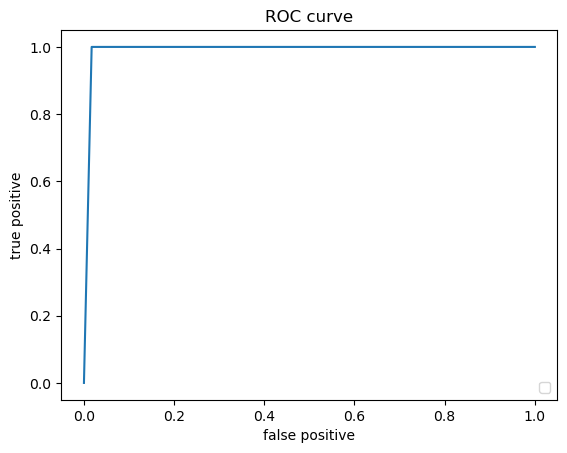

In [21]:
fpr, tpr, threshold, auc, ap = plot_roc(-pos_loss, -neg_loss)
plt.legend(loc='lower right')
plt.xlabel('false positive')
plt.ylabel('true positive')
plt.title('ROC curve')
plt.plot(fpr, tpr, label='%s attack, auc=%.3f, ap=%.3f' % ('Full Black-Box', auc, ap))
print("The AUC ROC value of %s attack is: %.3f " % ('Full Black-Box', auc))